In [1]:
import time
start_time = time.time()
from pathlib import Path
import numpy as np
import pandas as pd
import json
import cmasher as cmr
from matplotlib import pyplot as plt
import seaborn as sns
import sys
import corner

#import turbustat.statistics as tss
#import turbustat.simulator
#from turbustat.simulator import make_ppv
#from spectral_cube import SpectralCube  

#from astropy.io import fits
#from astropy.utils.misc import JsonCustomEncoder
#import astropy.units as u
#from astropy.convolution import Gaussian2DKernel, convolve_fft

import lmfit

sys.path.insert(1, 'C:/Users/ZAINTEL2/Documents/Aeon/GitHub/PhD.Paper/py-modules')  
from turb_utils import make_extended, make_3dfield
import strucfunc
import bfunc
import bplot

sns.set_color_codes()
sns.set_context("talk")

In [2]:
def ratio_empirical(rad, s0, a):
    """
    Simple tanh law in semi-log space to fit the seeing

    Reduction in B(r) is always 0.5 when r = 2 * s0
    Parameter `a` controls the slope of the transition.
    """
    #x = np.log(rad / (2 * s0))
    #y = np.tanh(a * x)
    #return 0.5 * (1.0 + y)

    x = ((2 * s0) / rad)**(2*a)
    return  (1.0 + x)**-1


def bfac(x, b):
    """
    Across-the board reduction in B(r) for x = s0 / r0

    Where s0 is RMS seeing width and r0 is correlation length
    """
    #return 1 / (1 + 4 * x ** 2)
    return np.exp(-x**(b))


def seeing_empirical(r, s0, r0, a, b, c ):
    return bfac((c*s0)/r0, b) * ratio_empirical(r, s0, a)

In [3]:
widths = [1, 2, 4, 8, 16, 32]

In [4]:
a = json.load(open("ratios_seeing.json"))

In [5]:
 widths

[1, 2, 4, 8, 16, 32]

In [6]:
r = a[str(widths[0])][1]

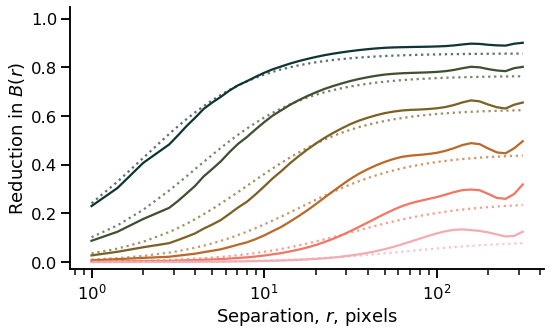

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))

colors = cmr.take_cmap_colors(
    "cmr.dusk",
    len(widths),
    cmap_range=(0.25, 0.95),
)

for i,c in zip(range(6), colors):
    ax.plot(r , a[str(widths[i])][0], color=c)
    
#for i,c in zip(range(6), colors):
#    ax.plot(r, seeing_empirical(np.array(r), widths[i], a[str(widths[i])][4], 0.9, 0.72), color=c, linestyle="dashed")
    
for i,c in zip(range(6), colors):
    ax.plot(r, seeing_empirical(np.array(r), widths[i], a[str(widths[i])][4], 0.675, 0.8, 0.95), color=c, linestyle=":", alpha = 0.7)

ax.set(
    xscale="log",
    yscale="linear",
    ylim=[-0.03,1.05],
    xlabel="Separation, $r$, pixels",
    ylabel="Reduction in $B(r)$",
)
sns.despine()
fig.tight_layout()

In [8]:
i = 0
B = np.array( a[str(widths[i])][0] )
r = np.array( r)

In [9]:
box_size = 365.03


In [10]:
relative_uncertainty = 0.03
#weights = 1.0 / (relative_uncertainty * B)
weights = 1.0 / (relative_uncertainty * (B))

large_scale = r > 0.5 * box_size
#weights[large_scale] /= 3.0
weights[:20] /= 1.5

In [11]:
model = lmfit.Model(seeing_empirical)
model.param_names

['s0', 'r0', 'a', 'b', 'c']

In [12]:
# Seeing pegged at width
model.set_param_hint(
    "s0", value =  widths[i], vary=False,
)

# Seeing RMS between 1 and 32 pix
#model.set_param_hint(
#    "s0", value = widths[i], min = widths[i] - 1, max = widths[i] + 1
#)

# corr length pegged 
model.set_param_hint(
    "r0", value=a[str(widths[i])][4], vary=False,
)
   
# Correlation length between 1/10 and 2 x box_size
#model.set_param_hint("r0", value=a[str(widths[i])][4], min=0.01 * box_size, max=2 * box_size)

# a between 1/2 and 1 
model.set_param_hint("a", value=0.875, min = 0.5 , max = 1.5 )

# b between 0.5 and 2.0
model.set_param_hint("b", value=0.825, min=0.5, max=1.5)

# c between 0.5 and 2.0
model.set_param_hint("c", value=1.0, vary=False)

In [13]:
pd.DataFrame(model.param_hints)

,s0,r0,a,b,c
value,1,9.92602,0.875,0.825,1
vary,False,False,NaN,NaN,False
min,NaN,NaN,0.500,0.500,NaN
max,NaN,NaN,1.500,1.500,NaN


In [14]:
to_fit = r <= 1.00 * box_size
#to_fit = ~large_scale

In [15]:
result = model.fit(B[to_fit], weights=weights[to_fit], r=r[to_fit])

In [16]:
result

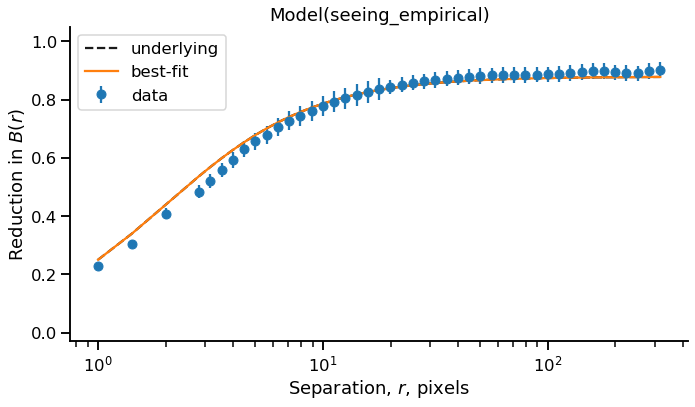

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the underlying model 
Bu = seeing_empirical(r, 
                      result.params["s0"].value, 
                      result.params["r0"].value, 
                      result.params["a"].value, 
                      result.params["b"].value, 
                      result.params["c"].value,)


ax.plot(r, Bu, color="k", linestyle="dashed", label="underlying")

result.plot_fit(ax=ax)

ax.set(
    xscale="log",
    yscale="linear",
    ylim=[-0.03,1.05],
    xlabel="Separation, $r$, pixels",
    ylabel="Reduction in $B(r)$",
)
sns.despine()
fig.tight_layout()

plt.savefig('Imgs//ratios_seeing_' + str(i) +'.pdf', bbox_inches='tight')

In [18]:
result.params["s0"].value, result.params["r0"].value, result.params["a"].value, result.params["b"].value, result.params["c"].value

(1, 9.926021195022425, 0.6641484826605462, 0.890521930248968, 1.0)

In [19]:
emcee_kws = dict(
    steps=10000, burn=1000, thin=50, is_weighted=True, progress=False, workers=16
)
emcee_params = result.params.copy()
# emcee_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2.0))

In [20]:
result_emcee = model.fit(
    data=B[to_fit],
    r=r[to_fit],
    weights=weights[to_fit],
    params=emcee_params,
    method="emcee",
    nan_policy="omit",
    fit_kws=emcee_kws,
)

In [21]:
#result_emcee

Text(0, 0.5, 'acceptance fraction')

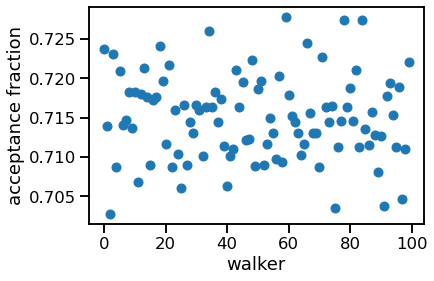

In [22]:
plt.plot(result_emcee.acceptance_fraction, "o")
plt.xlabel("walker")
plt.ylabel("acceptance fraction")

In [23]:
if hasattr(result_emcee, "acor"):
    print("Autocorrelation time for the parameters:")
    print("----------------------------------------")
    for y, p in enumerate(result_emcee.params):
        try:
            print(f"{p} = {result_emcee.acor[y]:.3f}")
        except IndexError:
            pass

Autocorrelation time for the parameters:
----------------------------------------
s0 = 30.746
r0 = 30.721


In [24]:
a[str(widths[i])][4]

9.926021195022425

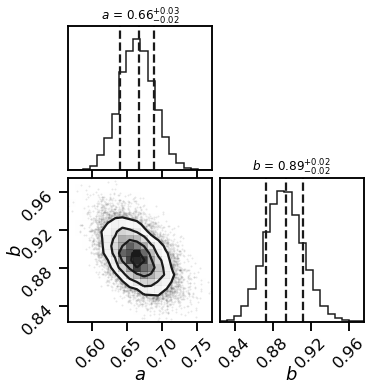

In [25]:
fig = corner.corner(result_emcee.flatchain,
                   labels=[
       # r"$s_0$",
        r"$a$",
        r"$b$",
        r"$c$",
    ],
    quantiles=[0.16, 0.55, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},)

#corner.overplot_lines(fig, value1, color="C1")

# This is the true mean of the second mode that we used above:
#value1 = mean

# This is the empirical mean of the sample:
#value2 = np.mean(samples, axis=0)
                   # Loop over the histograms
#for yi in range(ndim):
#    for xi in range(yi):
#        ax = axes[yi, xi]
#        ax.axvline(value1[xi], color="g")#

#        ax.axhline(value1[yi], color="g")

 #       ax.plot(value1[xi], value1[yi], "sg")

                   
                   #)

In [26]:
LM = {
    's0': [result.params['s0'].value,result.params['s0'].stderr],
    'r0': [result.params['r0'].value,result.params['r0'].stderr],
    'a' : [result.params['a'].value,result.params['a'].stderr],
    'b' : [result.params['b'].value,result.params['b'].stderr],
    'c' : [result.params['c'].value,result.params['c'].stderr],
}

In [27]:
LM

{'s0': [1, 0],
 'r0': [9.926021195022425, 0],
 'a': [0.6641484826605462, 0.023987494155264636],
 'b': [0.890521930248968, 0.01869588494717789],
 'c': [1.0, 0]}

In [28]:
MCMC = {
    's0': [result_emcee.params['s0'].value,result_emcee.params['s0'].stderr],
    'r0': [result_emcee.params['r0'].value,result_emcee.params['r0'].stderr],
    'a' : [result_emcee.params['a'].value,result_emcee.params['a'].stderr],
    'b' : [result_emcee.params['b'].value,result_emcee.params['b'].stderr],
    'c' : [result_emcee.params['c'].value,result_emcee.params['c'].stderr],
}

In [29]:
MCMC

{'s0': [1, None],
 'r0': [9.926021195022425, None],
 'a': [0.6638209832600486, 0.024411223320291775],
 'b': [0.8915112609136836, 0.019889417547410915],
 'c': [1.0, None]}

In [30]:
#r0s2 = np.percentile(result_emcee.flatchain['r0'],[2.5, 97.5])
bs2 = np.percentile(result_emcee.flatchain['b'],[2.5, 97.5])
#s0s2 = np.percentile(result_emcee.flatchain['s0'],[2.5, 97.5])
as2 = np.percentile(result_emcee.flatchain['a'],[2.5, 97.5])

In [31]:
#r0s2p = r0s2[1]-result.params['r0'].value
#r0s2m = result.params['r0'].value-r0s2[0]

bs2p = bs2[1]-result.params['b'].value
bs2m = result.params['b'].value-bs2[0]

#s0s2p = s0s2[1]-result.params['s0'].value
#s0s2m = result.params['s0'].value-s0s2[0]

as2p = as2[1]-result.params['a'].value
as2m = result.params['a'].value-as2[0]

results_2sig = {
#    'r0': [result.params['r0'].value,r0s2p,r0s2m],
    'n' : [result.params['n'].value,ns2p,ns2m],
#    's0': [result.params['s0'].value,s0s2p,s0s2m],
    'a' : [result.params['a'].value,as2p,as2m] 
    
}

In [32]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 69.4821629524231 seconds ---
